# Task 2: Building the baseline model

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

In [2]:
# List all physical GPUs available to TensorFlow
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPUs are available and recognized by TensorFlow:")
    for gpu in gpus:
        print(" -", gpu)
else:
    print("No GPU found. TensorFlow is running on the CPU.")


No GPU found. TensorFlow is running on the CPU.


In [3]:
import importlib
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import src.loading as loading
import src.models as models

importlib.reload(loading)
importlib.reload(models)

<module 'src.models' from 'c:\\Users\\seppe\\AI project\\AI-project\\notebooks\\src\\models.py'>

## 1. Set up the classification

In [4]:
# Choose a metric to evaluate the succes of the classifier.
metrics=['accuracy']

In [5]:
# Set a seed for NumPy and Keras for preproducibility.
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
# Set up image generators for the training, validation, and test data.
img_height, img_width = 128, 128
batch_size = 32
path = "../data"
train_data_gen, val_data_gen, train_and_val_data_gen, test_data_gen = loading.get_images(path, img_height, img_width, batch_size, norm="training")

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


## 2. Initial model

In [7]:
# Keras classifier model.
model = models.custom_CNN(
    (img_height, img_width, 1),
    dropout_rate = 0.1,
    filters = 16,
    dense_unit = 512,
    lr =0.001,
    metrics=metrics)

In [8]:
# Initial architecture.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,929 (32.09 MB)

 Trainable params: 8,412,929 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Training the initial model

In [9]:
total_train = train_data_gen.samples
total_val = val_data_gen.samples

print(f"total_train: {total_train}")
print(f"total_val: {total_val}")
print(f"batch_size: {batch_size}")
print(f"steps_per_epoch: {total_train // batch_size}")

total_train: 1600
total_val: 400
batch_size: 32
steps_per_epoch: 50


In [10]:
# Training the initial model.
epochs = 30

history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.6474 - loss: 0.8968 - val_accuracy: 0.7578 - val_loss: 0.5126
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.8820 - loss: 0.2936 - val_accuracy: 0.7500 - val_loss: 0.5163
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9151 - loss: 0.2026 - val_accuracy: 0.8281 - val_loss: 0.3776
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9370 - loss: 0.1586 - val_accuracy: 0.8802 - val_loss: 0.3064
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9618 - loss: 0.1135 - val_accuracy: 0.8047 - val_loss: 0.4464
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9465 - loss: 0.1305 - val_accuracy: 0.8620 - val_loss: 0.3512
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.9721 - loss: 0.0808 - val_accuracy: 0.8646 - val_loss: 0.3479
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9856 - loss: 0.0497 - val_accuracy: 0.

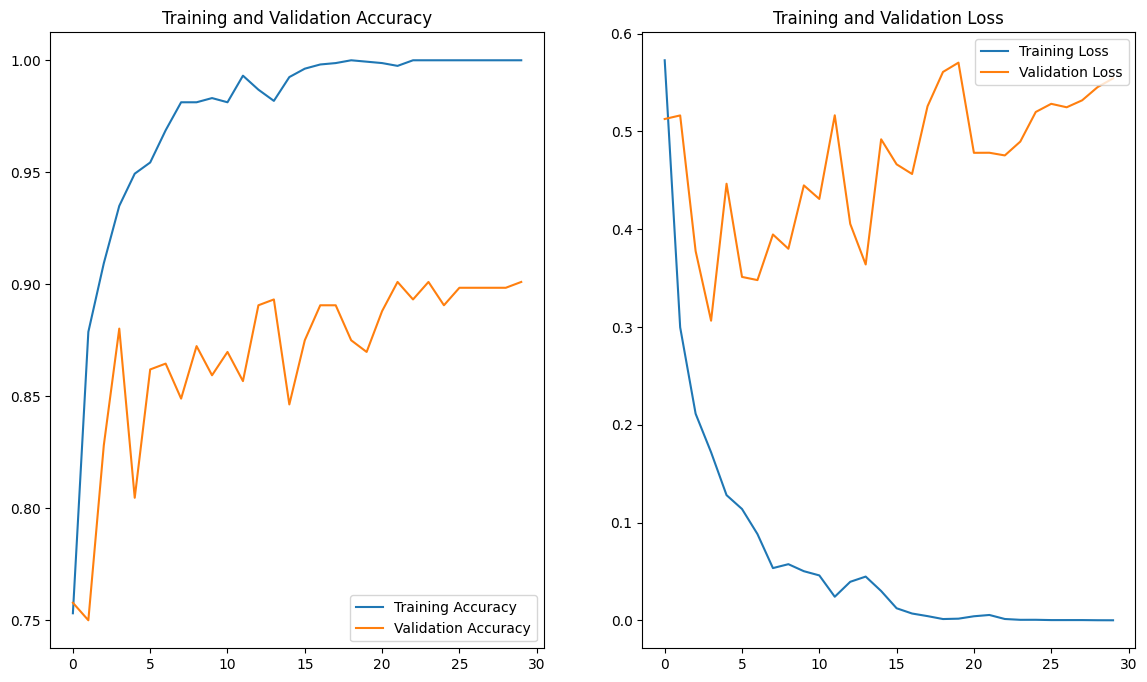

In [11]:
# Plot the model history.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 4. Hyperparameter tuning

In [12]:
# Implement the Keras EarlyStopping callback.
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [13]:
# Hyperparameter options.
dropout_rates = [0.1, 0.2]
first_filters = [16, 8]
learning_rates = [0.001, 0.0005]
dense_units = [512, 256]

# Create hyperparameter grid.
hyperparameter_grid = list(product(dropout_rates, first_filters, learning_rates, dense_units))

In [15]:
# Rough parameter search.
epochs = 30

total_iterations = len(hyperparameter_grid)
results = []  # List to store results from each run.

print(f"Total iterations: {total_iterations}")

for idx, (dropout_rate, filters, lr, dense_unit) in enumerate(hyperparameter_grid):
    print(f"\nRunning: dropout={dropout_rate}, filters={filters}, lr={lr}, dense_units={dense_unit}")
    
    # Build the model with the current hyperparameters.
    model = models.custom_CNN(
        (img_height, img_width, 1),
        dropout_rate=dropout_rate,
        filters=filters,
        dense_unit=dense_unit,
        lr=lr,
        metrics=metrics
    )
    
    # Train the model.
    history = model.fit(
        train_data_gen,
        steps_per_epoch=total_train // batch_size,
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=total_val // batch_size,
        callbacks=[early_stop],
        verbose=0  # Reduce training output during tuning.
    )
    
    # Find the best validation accuracy and the corresponding epoch.
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    final_val_loss = history.history['val_loss'][best_epoch - 1]
    
    # Append hyperparameters and performance metrics to the results.
    results.append({
        'dropout_rate': dropout_rate,
        'first_filters': filters,
        'learning_rate': lr,
        'dense_units': dense_unit,
        'best_val_accuracy': best_val_acc,
        'best_epoch': best_epoch,
        'final_val_loss': final_val_loss
    })
    print(f"Completed: best_val_accuracy={best_val_acc:.4f} at epoch {best_epoch}")

    print(idx + 1, "/", total_iterations, end="\r")  # Print progress.

# Move to a new line after the progress bar.
print("\nHyperparameter tuning complete.")

Total iterations: 16

Running: dropout=0.1, filters=16, lr=0.001, dense_units=512
Completed: best_val_accuracy=0.8490 at epoch 3
1 / 16
Running: dropout=0.1, filters=16, lr=0.001, dense_units=256
Completed: best_val_accuracy=0.8568 at epoch 2
2 / 16
Running: dropout=0.1, filters=16, lr=0.0005, dense_units=512
Completed: best_val_accuracy=0.8776 at epoch 5
3 / 16
Running: dropout=0.1, filters=16, lr=0.0005, dense_units=256
Completed: best_val_accuracy=0.8854 at epoch 7
4 / 16
Running: dropout=0.1, filters=8, lr=0.001, dense_units=512
Completed: best_val_accuracy=0.8594 at epoch 6
5 / 16
Running: dropout=0.1, filters=8, lr=0.001, dense_units=256
Completed: best_val_accuracy=0.8672 at epoch 8
6 / 16
Running: dropout=0.1, filters=8, lr=0.0005, dense_units=512
Completed: best_val_accuracy=0.8750 at epoch 6
7 / 16
Running: dropout=0.1, filters=8, lr=0.0005, dense_units=256
Completed: best_val_accuracy=0.8724 at epoch 9
8 / 16
Running: dropout=0.2, filters=16, lr=0.001, dense_units=512
Comple

In [16]:
# Create a DataFrame from the results and save to CSV.
df_results = pd.DataFrame(results)
csv_filename = "../results/hyperparameter_tuning_results_baseline.csv"
df_results.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

Results saved to ../results/hyperparameter_tuning_results_baseline.csv


## 5. Final baseline model

In [17]:
# Select the best configuration based on highest validation accuracy.
results_csv = "../results/hyperparameter_tuning_results_baseline.csv"
df_results = pd.read_csv(results_csv)

best_config = df_results.sort_values('best_val_accuracy', ascending=False).iloc[0]
best_dropout = best_config['dropout_rate']
best_filters = int(best_config['first_filters'])
best_lr = best_config['learning_rate']
best_dense_units = int(best_config['dense_units'])

print("Best Hyperparameters:")
print(best_config)

Best Hyperparameters:
dropout_rate           0.200000
first_filters         16.000000
learning_rate          0.001000
dense_units          512.000000
best_val_accuracy      0.903646
best_epoch             8.000000
final_val_loss         0.296636
Name: 8, dtype: float64


In [18]:
# Final baseline model
best_model = models.custom_CNN(
    (img_height, img_width, 1),
    dropout_rate = best_dropout,
    filters = best_filters,
    dense_unit = best_dense_units,
    lr = best_lr,
    metrics=metrics)

best_model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,929 (32.09 MB)

 Trainable params: 8,412,929 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
total_train_and_val = train_and_val_data_gen.samples

print(f"total_train_and_val: {total_train_and_val}")
print(f"batch_size: {batch_size}")
print(f"steps_per_epoch: {total_train_and_val // batch_size}")

total_train_and_val: 2000
batch_size: 32
steps_per_epoch: 62


In [20]:
# Retraining the model using the complete training dataset (including the validation dataset).
epochs_full = 8  # Adjust this as needed.

history_full = best_model.fit(
    train_and_val_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train_and_val // batch_size,
    epochs=epochs_full,
)

Epoch 1/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.6285 - loss: 0.9233
Epoch 2/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 134us/step - accuracy: 0.9375 - loss: 0.3245
Epoch 3/8


c:\Users\seppe\AI project\AI-project\.env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.8392 - loss: 0.3549
Epoch 4/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 104us/step - accuracy: 0.9375 - loss: 0.1633
Epoch 5/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.8861 - loss: 0.2599
Epoch 6/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step - accuracy: 1.0000 - loss: 0.0979
Epoch 7/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.9363 - loss: 0.1715
Epoch 8/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - accuracy: 1.0000 - loss: 0.0875


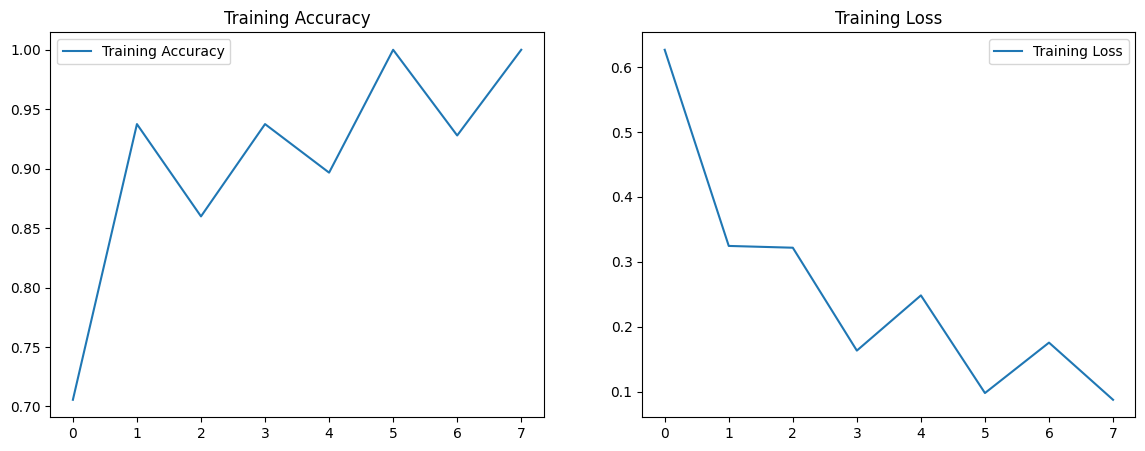

In [21]:
# Retrieve only the training history.
acc = history_full.history['accuracy']
loss = history_full.history['loss']
epochs_range = range(epochs_full)

# Plot only the training curves.
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [22]:
# Save the retrained model to disk.
model_save_path = "../results/final_baseline.keras"

best_model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to ../results/final_baseline.keras


In [23]:
# Reload the model from disk.
reloaded_model = load_model(model_save_path)
print("Model loaded from disk.")

Model loaded from disk.


In [24]:
total_test = test_data_gen.samples
steps_test = total_test // batch_size

print(f"total_test: {total_test}")
print(f"steps_test: {steps_test}")

total_test: 200
steps_test: 6


In [25]:
# Evaluate the reloaded model on the test set.
test_loss, test_accuracy = reloaded_model.evaluate(
    test_data_gen, 
    steps=steps_test,
    verbose=1,
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8870 - loss: 0.2656
Test Loss: 0.2835
Test Accuracy: 0.8750


In [26]:
# Generate predictions on the entire test set.
predictions = reloaded_model.predict(
    test_data_gen, 
    verbose=1
)

# For binary classification, use a threshold of 0.5.
predictions_class = (predictions > 0.5).astype(int).flatten()

# Get ground truth labels from the generator.
true_labels = test_data_gen.classes

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


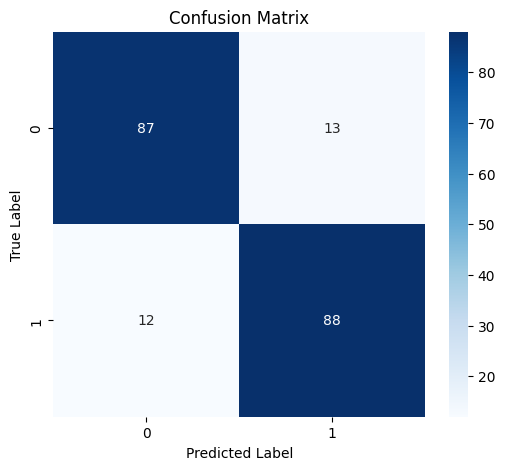

In [27]:
# Compute the confusion matrix.
cm = confusion_matrix(true_labels, predictions_class)

# Plot the confusion matrix.
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


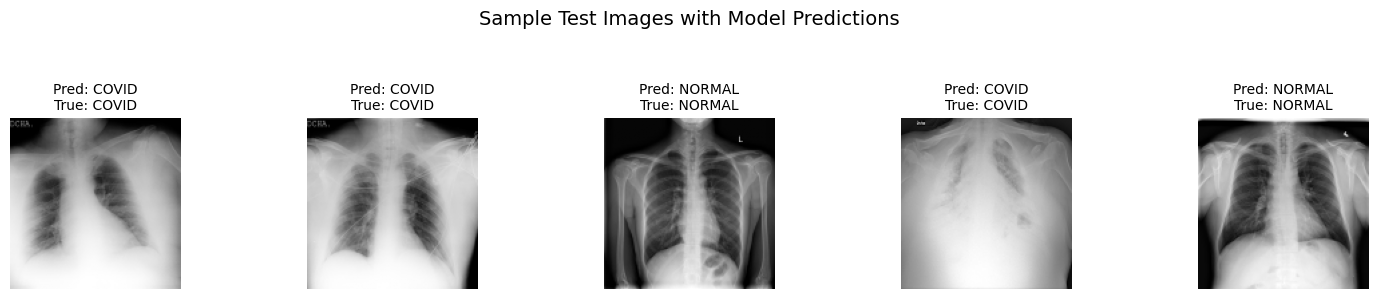

In [28]:
# Create a test data generator WITHOUT normalization (for displaying original images).
_, _, _, test_data_gen_no_norm = loading.get_images(
    path, 
    img_height, 
    img_width, 
    batch_size)

images, _, labels = loading.generator_to_array(test_data_gen_no_norm)

# Plot a few sample images with the predicted labels.
num_images_to_plot = 5
images_to_plot = random.sample(range(total_test), num_images_to_plot)
plt.figure(figsize=(15, 3))
for i, idx in enumerate(images_to_plot):
    plt.subplot(1, num_images_to_plot, i+1)
    # Display the original (non-normalized) image.
    plt.imshow(images[idx].astype("uint8"), cmap="gray")
    
    true_label = labels[idx]
    pred_label = test_data_gen.class_names[predictions_class[idx]]
    
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10)
    plt.axis('off')
plt.suptitle("Sample Test Images with Model Predictions", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.85])  # Leave space for suptitle
plt.show()

## Questions

**Question 7:** *Which metrics did you find appropriate for this task, and why?*

Accuracy, because it is really simple to understand. Detecting positive cases of covid could be more important. But given that there exists other far easier tests to diagnose covid, no more focus was given to the COVID class.

---

**Question 8:** *What conclusions can you draw from the training and validation curves on the history
plot of your initial model? Which hyperparameters would need to be optimized first?*

The model is completely overfitting the training set as it reaches 100% accuracy but it is 90% accurate on the validation set, which is quite good for an initial model. A less complex model by reducing the filters in the convolutional and/or neurons in the dense layers or regularization through dropout may be beneficial.

---

**Question 9:** *Did you observe signs of overfitting in your initial model? If so, which countermeasures against overfitting did you take?*

Same as question 8

---

**Question 10:** *Which hyperparameter search strategy did you employ? Did you attempt all possible
combinations of parameter values (grid search) or optimize them one at a time? If you tuned the
hyperparameters sequentially, did you select the values to try upfront, or did you base them on the
performance of previous values?*

A grid search of discrete values for the amount of filters in the convolutional layers, the amount of neurons in the dense layers, the learning rate and dropout was used.

---

**Question 11:** *Which optimizer and which loss function did you select for this problem? Did you
try others? How did you compare them?*

The Adam optimizer coupled with a binary cross entropy loss function was used because it is commonly used for binary classification problems.

---

**Question 12:** *What conclusions can you draw from the training curves on the history plot of your
final model?*

It will keep going down as the epochs increase, but since there is now no validation set available, the point at which the training is stopped is a guess.